# Setup & Data Import

In [1]:
# !pip install yfinance

# !pip install pycaret
# !pip install markupsafe==2.0.1
# !pip install Jinja2

In [2]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
btc_ticker = yf.Ticker('BTC-USD')
btc = btc_ticker.history(period="max")
btc = btc.drop(columns=['Dividends', 'Stock Splits'])

In [4]:
btc.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-28,20041.035156,20139.054688,19616.814453,19616.814453,24366810591
2022-08-29,19615.154297,20357.462891,19600.785156,20297.994141,32637854078
2022-08-30,20298.611328,20542.644531,19617.640625,19796.808594,34483360283
2022-08-31,19799.582031,20420.990234,19799.582031,20049.763672,33225232872
2022-09-01,20068.558594,20192.179688,19985.341797,20090.113281,31782529024


# Data Preparation

In [5]:
monthly_close = btc.groupby(btc.index.month)['Close'].tail(1)

In [6]:
# btc.resample('M', origin='end').mean().tail(10)

In [7]:
month_close_df = btc.copy()[btc.index.is_month_end]
month_close_df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

month_close_df.rename(columns={'Close':'month_close'}, inplace=True)


month_close_df

,month_close
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562


In [8]:
btc_month_mean = btc.resample('M').mean()
btc_month_mean.rename(columns={'Open':'month_ave_open', 'High':'month_ave_high', 'Low':'month_ave_low', 'Close':'month_ave_close', 'Volume':'month_ave_volume'}, inplace=True)
btc_month_mean.tail()


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume
Date,,,,,
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10
2022-09-30,20068.558594,20192.179688,19985.341797,20090.113281,3.178253e+10


In [9]:
btc_month_mean['month_ave_close_shift'] = btc_month_mean['month_ave_close'].shift(-1)
# btc_month_mean.dropna(inplace=True)
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift
Date,,,,,,
2014-09-30,412.654003,421.104422,398.174641,407.182428,2.934864e+07,364.148873
2014-10-31,365.748000,374.314260,354.856645,364.148873,2.912885e+07,366.099799
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645
...,...,...,...,...,...,...
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318


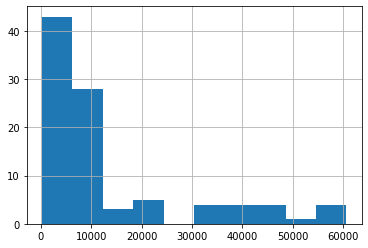

In [10]:
btc_month_mean['month_ave_close_shift'].hist()

In [11]:
btc_month_mean['month_ave_close_shift_diff'] = btc_month_mean['month_ave_close_shift'].diff()
btc_month_mean.dropna(inplace=True)

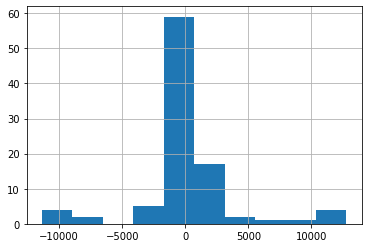

In [12]:
btc_month_mean['month_ave_close_shift_diff'].hist()

Dickey–Fuller test: p=0.102548


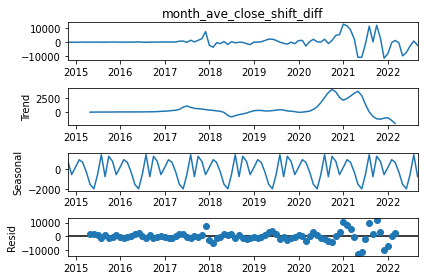

In [13]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff'])[1])

In [14]:
btc_month_mean.head(20)


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff
Date,,,,,,,
2014-10-31,365.748000,374.314260,354.856645,364.148873,2.912885e+07,366.099799,1.950926
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871,-24.831928
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974


In [15]:
btc_month_mean['month_ave_close_shift_diff_percent'] = None

for i in range(1, len(btc_month_mean)):
  btc_month_mean['month_ave_close_shift_diff_percent'][i] = \
  (btc_month_mean['month_ave_close_shift'][i] - btc_month_mean['month_ave_close_shift'][i-1]) / btc_month_mean['month_ave_close_shift'][i-1]

btc_month_mean.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
btc_month_mean

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871,-24.831928,-0.067828
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323,-0.271005
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903,-0.058802
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
...,...,...,...,...,...,...,...,...
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653


!! Stationary

Dickey–Fuller test: p=0.000000


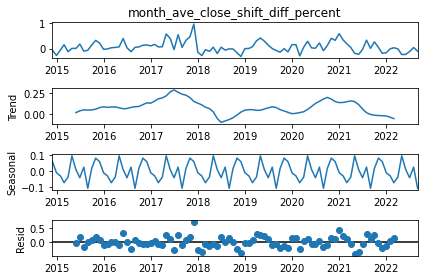

In [17]:
seasonal_decompose(btc_month_mean['month_ave_close_shift_diff_percent']).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month_mean['month_ave_close_shift_diff_percent'])[1])

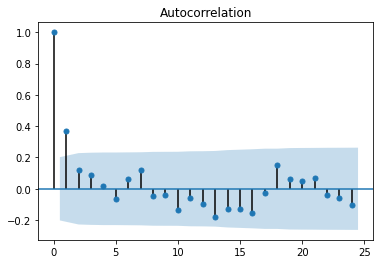

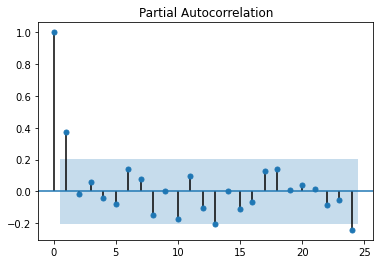

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);
plot_pacf(btc_month_mean['month_ave_close_shift_diff_percent'], lags=24);

## Train/Test Split + Scale Data

In [19]:
train_test_split = int(btc_month_mean.shape[0] * 0.75)
train = btc_month_mean.copy().iloc[:train_test_split]
test = btc_month_mean.copy().iloc[train_test_split:]
train.shape, test.shape

((70, 8), (24, 8))

In [20]:
train.columns

Index(['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close',
       'month_ave_volume', 'month_ave_close_shift',
       'month_ave_close_shift_diff', 'month_ave_close_shift_diff_percent'],
      dtype='object')

In [21]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

#hide warnings
train_scaled = pd.DataFrame()
test_scaled = pd.DataFrame()

train_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.fit_transform(train[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])
test_scaled[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']] = \
  scaler.transform(test[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume', 'month_ave_close', 'month_ave_close_shift_diff_percent']])

train_scaled.index = train.index
test_scaled.index = test.index

display(train_scaled.head())
display(test_scaled.tail())

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2014-11-30,0.008836,0.008840,0.009269,0.000100,0.008798,0.192411
2014-12-31,0.007379,0.007006,0.007789,0.000000,0.007149,0.032382
2015-01-31,0.001270,0.001562,0.000911,0.000423,0.001008,0.199520
2015-02-28,0.000000,0.000223,0.000000,0.000182,0.000037,0.363191
2015-03-31,0.002440,0.002413,0.002532,0.000315,0.002354,0.147613


,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close,month_ave_close_shift_diff_percent
Date,,,,,,
2022-04-30,2.774778,2.661495,2.905062,0.664579,2.735716,0.060894
2022-05-31,2.119331,2.048247,2.196297,0.856768,2.089714,0.063933
2022-06-30,1.643011,1.580276,1.684191,0.739741,1.603520,0.153954
2022-07-31,1.418240,1.376894,1.484209,0.718689,1.414655,0.276076
2022-08-31,1.488318,1.431173,1.564153,0.692803,1.469567,0.165679


In [22]:
X_train = train_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_train = train_scaled.copy()['month_ave_close_shift_diff_percent']

X_test = test_scaled.copy().drop(columns=['month_ave_close_shift_diff_percent'])
y_test = test_scaled.copy()['month_ave_close_shift_diff_percent']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 5), (70,), (24, 5), (24,))

In [23]:
X_train.head(20)

,month_ave_open,month_ave_high,month_ave_low,month_ave_volume,month_ave_close
Date,,,,,
2014-11-30,0.008836,0.008840,0.009269,0.000100,0.008798
2014-12-31,0.007379,0.007006,0.007789,0.000000,0.007149
2015-01-31,0.001270,0.001562,0.000911,0.000423,0.001008
2015-02-28,0.000000,0.000223,0.000000,0.000182,0.000037
2015-03-31,0.002440,0.002413,0.002532,0.000315,0.002354
2015-04-30,0.000193,0.000144,0.000284,0.000110,0.000126
2015-05-31,0.000290,0.000182,0.000513,0.000012,0.000226
2015-06-30,0.000276,0.000218,0.000520,0.000076,0.000298
2015-07-31,0.003081,0.003000,0.003365,0.000346,0.003052


# LinearRegression (static window)

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train) 
lr.score(X_train, y_train) 

0.4130837625034667

In [25]:
X_test_predict = lr.predict(X_test)

X_test_predict_df = pd.DataFrame(X_test_predict, index=X_test.index, columns=['Y_PRED'])
X_test_predict_df

,Y_PRED
Date,
2020-09-30,0.122398
2020-10-31,0.334955
2020-11-30,0.373815
2020-12-31,0.541257
2021-01-31,-0.257381
2021-02-28,0.615860
2021-03-31,0.372402
2021-04-30,-0.336695
2021-05-31,-0.685087


## Reassemble data frame with prediction

In [26]:
predict_df = test.merge(X_test_predict_df, how='left', on='Date')
predict_df

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072,0.122398
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087


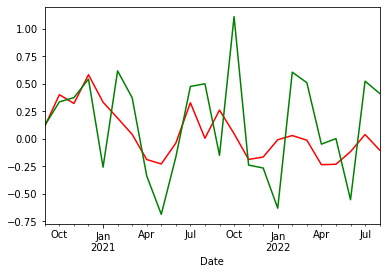

In [27]:
predict_df['month_ave_close_shift_diff_percent'].plot(c='red')
predict_df['Y_PRED'].plot(c='green')

In [28]:
#merge actual close with the dataframe
# predict_df = predict_df.merge(month_close_df, how='left', left_index=True, right_index=True)
predict_df


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED
Date,,,,,,,,,
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072,0.122398
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087


### append_gain_loss

In [29]:
#temp
month_close_df.tail()

,month_close
Date,
2022-04-30,37714.875000
2022-05-31,31792.310547
2022-06-30,19784.726562
2022-07-31,23336.896484
2022-08-31,20049.763672


In [30]:
#temp
# predict_df = append_gain_loss(predict_df)

In [31]:
# predict_df['gain_loss'] = predict_df['Close_shift'] - predict_df['Close']
# predict_df
def append_gain_loss(df):
  # display(month_close_df.head())
  df = df.merge(month_close_df, how='left', left_index=True, right_index=True)
  display(df.tail())
  
  # display(df.head())
  df['gain_loss'] = None
  for i in range(1, len(df)):
    df['gain_loss'][i] = df['month_close'][i] - df['month_close'][i-1]

  df.dropna(inplace=True)
  return df

predict_df = append_gain_loss(predict_df)
predict_df

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED,month_close
Date,,,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805,-0.048584,37714.875000
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947,0.001727,31792.310547
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653,-0.552567,19784.726562
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396,0.522681,23336.896484
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,20090.113281,-2276.153037,-0.101767,0.411875,20049.763672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent,Y_PRED,month_close,gain_loss
Date,,,,,,,,,,,
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335,0.334955,13780.995117,2996.503906
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645,0.373815,19625.835938,5844.84082
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287,0.541257,29001.720703,9375.884766
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123,-0.257381,33114.359375,4112.638672
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688,0.615860,45137.769531,12023.410156
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016,0.372402,58918.832031,13781.0625
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815,-0.336695,57750.175781,-1168.65625
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195,-0.685087,37332.855469,-20417.320312
2021-06-30,35920.546940,37094.880143,34375.803060,35845.154687,3.965492e+10,34444.973790,-1400.180897,-0.039062,-0.165558,35040.835938,-2292.019531


## Evaluate strategy

### if Y_PRED > 0

In [32]:
def calc_gain_loss(df, threshold, column):
  gain_loss = []
  for index, row in df.iterrows():
    if row[column] > threshold:
      print(f'{index}::{row[column]}')

      # gain_loss.append(row['Close_shift'] - row['Close'])
      gain_loss.append(row['gain_loss'])
      
  display(gain_loss)
  print(f'GAIN/LOSS: {sum(gain_loss)}')  

In [33]:
calc_gain_loss(predict_df, 0.0, 'Y_PRED')

2020-10-31 00:00:00::0.33495485246878876
2020-11-30 00:00:00::0.37381546177866565
2020-12-31 00:00:00::0.541256851393623
2021-02-28 00:00:00::0.6158604697166369
2021-03-31 00:00:00::0.37240151540230226
2021-07-31 00:00:00::0.4749515928902782
2021-08-31 00:00:00::0.4990607672427957
2021-10-31 00:00:00::1.1080569258106294
2022-02-28 00:00:00::0.6043118221640854
2022-03-31 00:00:00::0.5088890460004195
2022-05-31 00:00:00::0.001727364110415519
2022-07-31 00:00:00::0.5226811765243299
2022-08-31 00:00:00::0.4118746476941447


[2996.50390625,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 13781.0625,
 6585.359375,
 5540.4921875,
 17528.0625,
 4710.109375,
 2345.44140625,
 -5922.564453125,
 3552.169921875,
 -3287.1328125]

GAIN/LOSS: 75073.6396484375


### if Y_PRED > .1


In [34]:
calc_gain_loss(predict_df, 0.1, 'Y_PRED')

2020-10-31 00:00:00::0.33495485246878876
2020-11-30 00:00:00::0.37381546177866565
2020-12-31 00:00:00::0.541256851393623
2021-02-28 00:00:00::0.6158604697166369
2021-03-31 00:00:00::0.37240151540230226
2021-07-31 00:00:00::0.4749515928902782
2021-08-31 00:00:00::0.4990607672427957
2021-10-31 00:00:00::1.1080569258106294
2022-02-28 00:00:00::0.6043118221640854
2022-03-31 00:00:00::0.5088890460004195
2022-07-31 00:00:00::0.5226811765243299
2022-08-31 00:00:00::0.4118746476941447


[2996.50390625,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 13781.0625,
 6585.359375,
 5540.4921875,
 17528.0625,
 4710.109375,
 2345.44140625,
 3552.169921875,
 -3287.1328125]

GAIN/LOSS: 80996.2041015625


### if Y_PRED > .20

In [35]:
calc_gain_loss(predict_df, 0.2, 'Y_PRED')

2020-10-31 00:00:00::0.33495485246878876
2020-11-30 00:00:00::0.37381546177866565
2020-12-31 00:00:00::0.541256851393623
2021-02-28 00:00:00::0.6158604697166369
2021-03-31 00:00:00::0.37240151540230226
2021-07-31 00:00:00::0.4749515928902782
2021-08-31 00:00:00::0.4990607672427957
2021-10-31 00:00:00::1.1080569258106294
2022-02-28 00:00:00::0.6043118221640854
2022-03-31 00:00:00::0.5088890460004195
2022-07-31 00:00:00::0.5226811765243299
2022-08-31 00:00:00::0.4118746476941447


[2996.50390625,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 13781.0625,
 6585.359375,
 5540.4921875,
 17528.0625,
 4710.109375,
 2345.44140625,
 3552.169921875,
 -3287.1328125]

GAIN/LOSS: 80996.2041015625


In [36]:
predict_df.shape

(23, 11)

In [37]:
#find residuals and P values
from statsmodels.api import OLS

ols = OLS(y_train, X_train).fit()

In [38]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     month_ave_close_shift_diff_percent   R-squared (uncentered):                   0.498
Model:                                            OLS   Adj. R-squared (uncentered):              0.459
Method:                                 Least Squares   F-statistic:                              12.87
Date:                                Thu, 01 Sep 2022   Prob (F-statistic):                    1.05e-08
Time:                                        05:20:29   Log-Likelihood:                        -0.62710
No. Observations:                                  70   AIC:                                      11.25
Df Residuals:                                      65   BIC:                                      22.50
Df Model:                                           5                                                  
Covariance Type:                            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
month_ave_open     -85.3666     18.876     -4.523      0.000    -123.064     -47.669
month_ave_high      82.7441     27.196      3.043      0.003      28.431     137.058
month_ave_low       62.0640     18.267      3.398      0.001      25.581      98.547
month_ave_volume    -0.2290      0.174     -1.317      0.193      -0.577       0.118
month_ave_close    -59.0953     31.294     -1.888      0.063    -121.594       3.403
==============================================================================
Omnibus:                        0.730   Durbin-Watson:                   0.574
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.807
Skew:                          -0.108   Prob(JB):                        0.668
Kurtosis:                       2.521   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

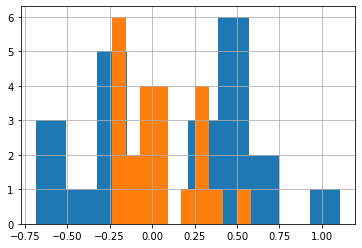

In [39]:
predict_df['Y_PRED'].hist()
predict_df['month_ave_close_shift_diff_percent'].hist()

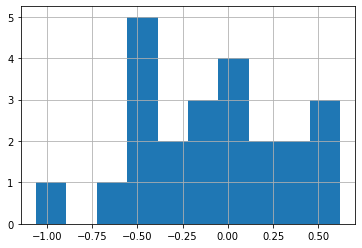

In [40]:
(predict_df['month_ave_close_shift_diff_percent']-predict_df['Y_PRED']).hist()

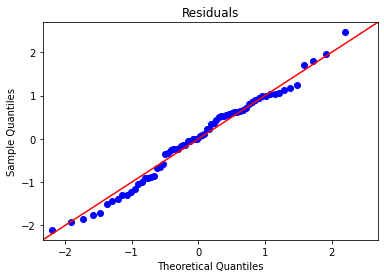

In [41]:
sm.qqplot(ols.resid, fit=True, line='45')
plt.title('Residuals')
plt.show()

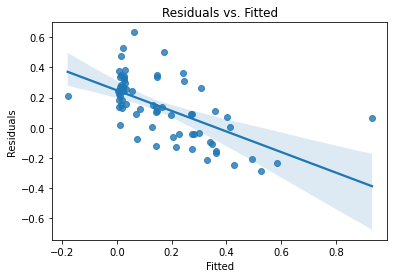

In [42]:
sns.regplot(x=ols.fittedvalues, y=ols.resid)
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Linear Regression (Sliding 'X' month window)


In [43]:
btc_month_mean.tail()

,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2022-04-30,41694.653646,42328.085156,40805.150260,41435.319661,2.767053e+10,31706.105217,-9729.214445,-0.234805
2022-05-31,31900.711127,32629.598349,30905.249244,31706.105217,3.566740e+10,24383.685482,-7322.419735,-0.230947
2022-06-30,24783.338477,25228.663672,23752.240495,24383.685482,3.079797e+10,21539.253843,-2844.431639,-0.116653
2022-07-31,21424.733052,22012.192729,20958.936996,21539.253843,2.992201e+10,22366.266318,827.012475,0.038396
2022-08-31,22471.866557,22870.607863,22075.572203,22366.266318,2.884492e+10,20090.113281,-2276.153037,-0.101767


In [44]:
# btc_month_mean[47:92+1]

In [53]:
window_size = 24
predict_df = pd.DataFrame(columns=['Y_PRED'])
btc_month_mean.shape

for i in range(window_size, btc_month_mean.shape[0]+1):
  print(f'{i-window_size}->{i}')

  window_data = btc_month_mean[i-window_size:i]
  display(window_data)

  X = window_data.copy()[['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_close', 'month_ave_volume']]

  X_train = X[:X.shape[0]-1]
  X_pred = X[X.shape[0]-1:]
  # print(f'X_pred: >>>{X[X.shape[0]-1:]}<<<::>>{X[X.shape[0]:]}<<')

  y = window_data['month_ave_close_shift_diff_percent']
  y_train = y[:X.shape[0]-1]

  lr = LinearRegression()
  lr.fit(X_train, y_train) 
  y_pred = lr.predict(X_pred)[0]

  y_pred_df = pd.DataFrame(data=[y_pred], columns=['Y_PRED'], index=[X_pred.index[0]])
  predict_df = pd.concat([predict_df, pd.DataFrame(y_pred_df)], ignore_index=False)

  # break
predict_df.tail(20)

0->24


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,341.267871,-24.831928,-0.067828
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323,-0.271005
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903,-0.058802
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125


1->25


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,248.782547,-92.485323,-0.271005
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903,-0.058802
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352


2->26


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,234.153645,-14.628903,-0.058802
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382


3->27


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-02-28,232.821856,240.211430,227.769678,234.153645,2.541138e+07,269.042259,34.888614,0.148999
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726


4->28


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-03-31,269.278419,274.850999,263.134162,269.042259,3.093865e+07,235.491534,-33.550725,-0.124704
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638


5->29


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-04-30,235.708668,238.957098,231.734033,235.491534,2.241129e+07,236.997001,1.505467,0.006393
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088


6->30


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-05-31,237.161806,239.563161,234.939388,236.997001,1.832654e+07,238.081766,1.084765,0.004577
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666


7->31


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-06-30,236.941433,240.127034,235.028233,238.081766,2.099267e+07,279.563740,41.481974,0.174234
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964


8->32


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-07-31,278.857679,284.122356,274.771742,279.563740,3.225459e+07,250.733805,-28.829935,-0.103125
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767


9->33


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-08-31,252.986774,256.415905,247.146256,250.733805,2.919975e+07,233.595533,-17.138272,-0.068352
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579


10->34


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-09-30,233.486733,236.684667,231.632166,233.595533,2.012080e+07,264.855356,31.259822,0.13382
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629


11->35


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-10-31,262.306000,267.740645,260.490968,264.855356,3.075095e+07,348.883332,84.027977,0.31726
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757


12->36


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-11-30,346.866833,361.374567,336.263869,348.883332,7.258745e+07,424.464547,75.581215,0.216638
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641


13->37


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2015-12-31,422.618033,431.568609,413.460000,424.464547,6.762097e+07,410.844485,-13.620062,-0.032088
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314


14->38


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-01-31,412.805902,418.802354,403.495161,410.844485,6.422195e+07,404.408274,-6.436212,-0.015666
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231


15->39


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-02-29,402.304692,408.422725,398.191209,404.408274,6.469789e+07,416.525774,12.117500,0.029964
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658


16->40


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-03-31,417.262033,420.026969,413.330710,416.525774,7.525332e+07,434.339398,17.813625,0.042767
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031


17->41


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-04-30,433.487433,436.753132,430.642734,434.339398,6.038251e+07,461.954415,27.615016,0.063579
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891


18->42


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-05-31,459.237547,466.128643,455.772068,461.954415,7.207848e+07,642.869061,180.914647,0.391629
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345


19->43


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-06-30,638.544834,657.879266,619.871529,642.869061,1.583234e+08,661.356103,18.487041,0.028757
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898


20->44


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-07-31,662.977779,670.275194,652.487704,661.356103,1.114254e+08,579.585197,-81.770906,-0.123641
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424


21->45


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-08-31,581.238966,586.166354,574.551059,579.585197,8.665226e+07,605.848633,26.263436,0.045314
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793


22->46


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-09-30,604.614034,608.348033,601.865637,605.848633,6.681338e+07,643.550935,37.702302,0.062231
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855


23->47


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-10-31,640.702546,646.446291,638.004255,643.550935,6.824012e+07,726.349101,82.798166,0.128658
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301


24->48


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-11-30,725.073804,733.669468,716.785199,726.349101,8.785910e+07,828.060356,101.711255,0.140031
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431


25->49


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2016-12-31,821.108255,832.505030,814.082807,828.060356,1.147343e+08,914.916159,86.855803,0.104891
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371


26->50


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-01-31,914.680971,937.449585,887.202387,914.916159,1.659346e+08,1062.533672,147.617512,0.161345
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644


27->51


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-02-28,1055.620071,1073.503898,1040.417923,1062.533672,1.529558e+08,1129.365228,66.831557,0.062898
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655


28->52


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-03-31,1133.212576,1161.893269,1099.865671,1129.365228,3.507244e+08,1206.641007,77.275779,0.068424
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508


29->53


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-04-30,1197.646997,1216.302983,1188.384998,1206.641007,3.252483e+08,1895.383529,688.742522,0.570793
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414


30->54


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-05-31,1865.748712,1968.786783,1812.038078,1895.383529,1.105221e+09,2636.204346,740.820817,0.390855
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148


31->55


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-06-30,2630.573332,2712.255656,2538.007015,2636.204346,1.482605e+09,2519.418386,-116.785960,-0.044301
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549


32->56


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-07-31,2509.213233,2603.998701,2425.572919,2519.418386,1.052257e+09,3880.989998,1361.571612,0.540431
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383


33->57


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-08-31,3819.812579,3953.132907,3719.479350,3880.989998,2.049936e+09,4064.836312,183.846314,0.047371
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957


34->58


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-09-30,4077.400993,4214.381632,3906.034993,4064.836312,1.856698e+09,5360.071604,1295.235292,0.318644
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613


35->59


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-10-31,5291.370007,5450.295505,5176.274839,5360.071604,1.871270e+09,7813.132975,2453.061371,0.457655
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938


36->60


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-11-30,7685.745996,8084.058008,7479.071647,7813.132975,4.691167e+09,15294.270980,7481.138005,0.957508
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244


37->61


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2017-12-31,15175.219601,16051.632277,14195.588773,15294.270980,1.323666e+10,13085.558090,-2208.712891,-0.144414
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351


38->62


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-01-31,13212.074219,13705.425781,12381.951991,13085.558090,1.342735e+10,9472.001151,-3613.556939,-0.276148
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993


39->63


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-02-28,9462.242920,9914.565290,8948.848546,9472.001151,8.204206e+09,9040.557097,-431.444054,-0.045549
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669


40->64


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-03-31,9156.591718,9373.206401,8743.681940,9040.557097,6.250055e+09,8033.596631,-1006.960467,-0.111383
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118


41->65


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-04-30,7963.618311,8209.301025,7787.209310,8033.596631,6.551667e+09,8450.997732,417.401101,0.051957
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286


42->66


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-05-31,8505.240675,8638.819966,8283.560657,8450.997732,6.374571e+09,6793.507666,-1657.490066,-0.19613
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797


43->67


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-06-30,6829.257975,6930.069027,6670.762646,6793.507666,4.340473e+09,7146.349987,352.842321,0.051938
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166


44->68


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-07-31,7101.466450,7258.952589,6982.127426,7146.349987,4.562643e+09,6700.129946,-446.220042,-0.06244
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409


45->69


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-08-31,6723.800955,6849.496141,6580.563555,6700.129946,4.267509e+09,6610.675033,-89.454913,-0.013351
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555


46->70


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-09-30,6622.821338,6709.125684,6521.042985,6610.675033,4.324846e+09,6485.118747,-125.556286,-0.018993
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139


47->71


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-10-31,6494.016491,6550.149698,6443.752599,6485.118747,3.820545e+09,5404.250171,-1080.868576,-0.166669
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119


48->72


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-11-30,5481.615120,5561.603516,5295.466585,5404.250171,5.278651e+09,3717.488344,-1686.761827,-0.312118
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445


49->73


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2018-12-31,3726.475106,3840.127426,3623.742235,3717.488344,5.446026e+09,3701.554963,-15.933381,-0.004286
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907


50->74


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-01-31,3709.705645,3755.834032,3655.715584,3701.554963,5.397926e+09,3711.907261,10.352298,0.002797
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287


51->75


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-02-28,3697.178327,3752.559317,3659.893598,3711.907261,7.110738e+09,3976.069100,264.161838,0.071166
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456


52->76


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-03-31,3967.740400,4008.783707,3937.973444,3976.069100,9.611380e+09,5178.469434,1202.400334,0.302409
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119


53->77


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-04-30,5136.813314,5258.515446,5074.575374,5178.469434,1.484549e+10,7309.694131,2131.224698,0.411555
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737


54->78


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-05-31,7205.208024,7466.774493,7047.033376,7309.694131,2.335993e+10,9415.900179,2106.206048,0.288139
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981


55->79


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-06-30,9339.480322,9702.517822,9058.600179,9415.900179,2.252851e+10,10669.336158,1253.435979,0.133119
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552


56->80


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-07-31,10691.706055,11025.668032,10290.467427,10669.336158,2.181988e+10,10643.248362,-26.087796,-0.002445
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442


57->81


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-08-31,10657.745621,10861.748047,10385.926128,10643.248362,1.722532e+10,9814.067871,-829.180491,-0.077907
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219


58->82


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-09-30,9858.141813,9973.392025,9647.338005,9814.067871,1.601817e+10,8411.929168,-1402.138703,-0.14287
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406


59->83


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-10-31,8382.432129,8577.835418,8249.077117,8411.929168,1.920017e+10,8373.572412,-38.356756,-0.00456
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609


60->84


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-11-30,8427.103516,8542.317318,8245.797868,8373.572412,2.256398e+10,7284.013042,-1089.559370,-0.130119
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069


61->85


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2019-12-31,7296.351626,7411.171276,7175.216057,7284.013042,2.044485e+10,8389.270476,1105.257434,0.151737
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143


62->86


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-01-31,8318.949597,8490.318659,8202.997244,8389.270476,2.751201e+10,9630.722185,1241.451708,0.147981
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072


63->87


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-02-29,9656.215113,9791.161806,9473.436961,9630.722185,4.011643e+10,6871.016113,-2759.706072,-0.286552
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335


64->88


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-03-31,6943.507009,7182.894547,6619.607406,6871.016113,4.162716e+10,7224.477327,353.461214,0.051442
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645


65->89


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-04-30,7150.611328,7352.325505,7045.441878,7224.477327,3.853757e+10,9263.151745,2038.674418,0.28219
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287


66->90


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-05-31,9237.761530,9451.186964,9048.870621,9263.151745,4.149575e+10,9489.227214,226.075468,0.024406
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123


67->91


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-06-30,9499.797005,9606.907943,9342.357031,9489.227214,2.169711e+10,9589.899729,100.672516,0.010609
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688


68->92


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-07-31,9519.383852,9672.627709,9434.339718,9589.899729,1.760688e+10,11652.394185,2062.494456,0.215069
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016


69->93


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-08-31,11639.097215,11827.761278,11453.378749,11652.394185,2.285087e+10,10660.276855,-992.117329,-0.085143
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815


70->94


,month_ave_open,month_ave_high,month_ave_low,month_ave_close,month_ave_volume,month_ave_close_shift,month_ave_close_shift_diff,month_ave_close_shift_diff_percent
Date,,,,,,,,
2020-09-30,10689.700163,10844.910254,10470.011263,10660.276855,3.586498e+10,11886.978201,1226.701345,0.115072
2020-10-31,11791.307491,12018.847719,11648.076833,11886.978201,3.389918e+10,16645.757422,4758.779221,0.400335
2020-11-30,16450.121647,16945.980208,16064.074740,16645.757422,3.643816e+10,21983.137097,5337.379675,0.320645
2020-12-31,21680.540827,22354.685610,21229.362021,21983.137097,3.910515e+10,34761.649950,12778.512853,0.581287
2021-01-31,34652.961694,36206.557082,32705.655998,34761.649950,6.946688e+10,46306.798968,11545.149018,0.332123
2021-02-28,45874.967215,47710.414621,44197.377302,46306.798968,8.096975e+10,54998.008695,8691.209727,0.187688
2021-03-31,54544.678175,56250.979083,52964.134703,54998.008695,5.423175e+10,57206.720052,2208.711358,0.04016
2021-04-30,57251.256250,58557.342057,55604.271094,57206.720052,6.148273e+10,46443.286668,-10763.433384,-0.18815
2021-05-31,47105.828503,48775.041835,44434.530620,46443.286668,6.376108e+10,35845.154687,-10598.131981,-0.228195


,Y_PRED
2021-01-31,-0.076242
2021-02-28,0.341997
2021-03-31,-0.064244
2021-04-30,-1.477147
2021-05-31,-1.177230
2021-06-30,-0.029548
2021-07-31,0.049680
2021-08-31,0.080318
2021-09-30,-0.156167
2021-10-31,0.339727


### append_gain_loss(predict_df)

In [54]:
predict_df = append_gain_loss(predict_df)

,Y_PRED,month_close
2022-04-30,-0.156535,37714.875000
2022-05-31,-0.022516,31792.310547
2022-06-30,-0.000664,19784.726562
2022-07-31,0.162727,23336.896484
2022-08-31,0.010264,20049.763672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [55]:
df = calc_gain_loss(predict_df, 0, 'Y_PRED')
df

2016-12-31 00:00:00::0.20478862521304142
2017-02-28 00:00:00::0.17707510179555214
2017-03-31 00:00:00::0.21774981397299645
2017-04-30 00:00:00::0.26347417331815676
2017-05-31 00:00:00::2.8149614745174247
2017-07-31 00:00:00::0.08111201913325958
2017-08-31 00:00:00::0.24665160324492014
2017-09-30 00:00:00::0.09869683559505923
2017-10-31 00:00:00::0.8828128808253607
2017-11-30 00:00:00::1.9449433327782377
2018-02-28 00:00:00::0.3331820390458521
2018-03-31 00:00:00::0.355004733879532
2018-04-30 00:00:00::0.5586613106196635
2018-05-31 00:00:00::0.029160397802116197
2018-06-30 00:00:00::0.055653901338831455
2018-07-31 00:00:00::0.11545318365440033
2018-08-31 00:00:00::0.18694941958333938
2018-10-31 00:00:00::0.03991159232768968
2019-04-30 00:00:00::0.07147995359287618
2019-05-31 00:00:00::0.35767154757575
2019-06-30 00:00:00::0.3257387436655307
2019-10-31 00:00:00::0.2594766270230043
2019-11-30 00:00:00::0.05000132353037898
2019-12-31 00:00:00::0.04441363861356265
2020-01-31 00:00:00::0.273

[218.052001953125,
 209.56695556640625,
 -108.179931640625,
 276.0999755859375,
 938.5198974609375,
 394.5,
 1828.050048828125,
 -364.68017578125,
 2129.68994140625,
 3765.19970703125,
 176.80078125,
 -3424.37060546875,
 2267.02001953125,
 -1746.3798828125,
 -1090.169921875,
 1376.43994140625,
 -742.85986328125,
 -307.9501953125,
 1245.322265625,
 3223.775390625,
 2242.6533203125,
 905.716796875,
 -1629.955078125,
 -376.03076171875,
 2156.93017578125,
 -751.0205078125,
 2219.9091796875,
 802.5048828125,
 2185.4736328125,
 2996.50390625,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 6585.359375,
 5540.4921875,
 17528.0625,
 4710.109375,
 3552.169921875,
 -3287.1328125]

GAIN/LOSS: 82890.32818603516


In [56]:
calc_gain_loss(predict_df, 0.1, 'Y_PRED')

2016-12-31 00:00:00::0.20478862521304142
2017-02-28 00:00:00::0.17707510179555214
2017-03-31 00:00:00::0.21774981397299645
2017-04-30 00:00:00::0.26347417331815676
2017-05-31 00:00:00::2.8149614745174247
2017-08-31 00:00:00::0.24665160324492014
2017-10-31 00:00:00::0.8828128808253607
2017-11-30 00:00:00::1.9449433327782377
2018-02-28 00:00:00::0.3331820390458521
2018-03-31 00:00:00::0.355004733879532
2018-04-30 00:00:00::0.5586613106196635
2018-07-31 00:00:00::0.11545318365440033
2018-08-31 00:00:00::0.18694941958333938
2019-05-31 00:00:00::0.35767154757575
2019-06-30 00:00:00::0.3257387436655307
2019-10-31 00:00:00::0.2594766270230043
2020-01-31 00:00:00::0.27395991708414336
2020-02-29 00:00:00::0.11183572249116885
2020-04-30 00:00:00::0.26037345905953424
2020-10-31 00:00:00::0.19897286133573738
2020-11-30 00:00:00::0.43197038762654066
2020-12-31 00:00:00::0.4519989812068901
2021-02-28 00:00:00::0.34199669217988604
2021-10-31 00:00:00::0.33972651293163697
2022-07-31 00:00:00::0.162726

[218.052001953125,
 209.56695556640625,
 -108.179931640625,
 276.0999755859375,
 938.5198974609375,
 1828.050048828125,
 2129.68994140625,
 3765.19970703125,
 176.80078125,
 -3424.37060546875,
 2267.02001953125,
 1376.43994140625,
 -742.85986328125,
 3223.775390625,
 2242.6533203125,
 905.716796875,
 2156.93017578125,
 -751.0205078125,
 2219.9091796875,
 2996.50390625,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 17528.0625,
 3552.169921875]

GAIN/LOSS: 70228.86529541016


In [57]:
calc_gain_loss(predict_df, 0.2, 'Y_PRED')

2016-12-31 00:00:00::0.20478862521304142
2017-03-31 00:00:00::0.21774981397299645
2017-04-30 00:00:00::0.26347417331815676
2017-05-31 00:00:00::2.8149614745174247
2017-08-31 00:00:00::0.24665160324492014
2017-10-31 00:00:00::0.8828128808253607
2017-11-30 00:00:00::1.9449433327782377
2018-02-28 00:00:00::0.3331820390458521
2018-03-31 00:00:00::0.355004733879532
2018-04-30 00:00:00::0.5586613106196635
2019-05-31 00:00:00::0.35767154757575
2019-06-30 00:00:00::0.3257387436655307
2019-10-31 00:00:00::0.2594766270230043
2020-01-31 00:00:00::0.27395991708414336
2020-04-30 00:00:00::0.26037345905953424
2020-11-30 00:00:00::0.43197038762654066
2020-12-31 00:00:00::0.4519989812068901
2021-02-28 00:00:00::0.34199669217988604
2021-10-31 00:00:00::0.33972651293163697


[218.052001953125,
 -108.179931640625,
 276.0999755859375,
 938.5198974609375,
 1828.050048828125,
 2129.68994140625,
 3765.19970703125,
 176.80078125,
 -3424.37060546875,
 2267.02001953125,
 3223.775390625,
 2242.6533203125,
 905.716796875,
 2156.93017578125,
 2219.9091796875,
 5844.8408203125,
 9375.884765625,
 12023.41015625,
 17528.0625]

GAIN/LOSS: 63588.06494140625


# PyCaret

In [47]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [48]:
# train_scaled.index = train.index
# test_scaled.index = test.index
train_scaled.columns

Index(['month_ave_open', 'month_ave_high', 'month_ave_low', 'month_ave_volume',
       'month_ave_close', 'month_ave_close_shift_diff_percent'],
      dtype='object')

In [49]:
# from pycaret.regression import *
pycaret_exp = setup(data=train_scaled, target='month_ave_close_shift_diff_percent', session_id=123) 

NameError: ignored

In [ ]:
best = compare_models()

In [ ]:
models()

## Huber Model

In [ ]:
def evaluate_pycaret_model(model_string, show_plots=False):
  model = create_model(model_string)
  tuned_model = tune_model(model)
  print(tuned_model)

  if show_plots:
    plot_model(tuned_model)
    plot_model(tuned_model, plot = 'error')
    plot_model(tuned_model, plot='feature')
  
  evaluate_model(tuned_model)
  predict_model(tuned_model);
  predictions = predict_model(tuned_model, data=test_scaled)

  predictions = append_gain_loss(predictions)
  
  return predictions


In [ ]:
huber_model = create_model('huber')

In [ ]:
tuned_huber_model = tune_model(huber_model)

In [ ]:
print(tuned_huber_model)

In [ ]:
plot_model(tuned_huber_model)

In [ ]:
plot_model(tuned_huber_model, plot = 'error')

In [ ]:
plot_model(tuned_huber_model, plot='feature')

In [ ]:
evaluate_model(tuned_huber_model)

In [ ]:
predict_model(tuned_huber_model);

In [ ]:
unseen_predictions = predict_model(tuned_huber_model, data=test_scaled)


In [ ]:
unseen_predictions.head(20)

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.month_ave_close_shift_diff_percent, unseen_predictions.Label, 'R2')

In [ ]:
# unseen_predictions = unseen_predictions.merge(month_close_df, how='left', left_index=True, right_index=True)
unseen_predictions = append_gain_loss(unseen_predictions)
calc_gain_loss(unseen_predictions, 0.0, 'Label')

In [ ]:
calc_gain_loss(unseen_predictions, 0.1, 'Label')

In [ ]:
calc_gain_loss(unseen_predictions, 0.2, 'Label')

## Random Forest

In [ ]:
rf_predictions = evaluate_pycaret_model('rf', True)

In [ ]:
rf_predictions